# Lab 4
## Using the data from following table create a model predicting number of passenger deaths.
Use poisson distribution in two variants

1. The rate is constant for all years and not depending on anything.
2. The intensity is constant, but rate is a product of intensity and miles flown.

Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

Plane has an abstract traits: $$\frac{number of\ critical \ malfunctions}{miles \ flown}$$ and
$$\frac{number of\ passenger \ fatalities}{miles \ flown}$$

And second one will be diagnosed.

Guessing the prediction about the death rate is forbidden because there is enormous uncertainty between $\frac{0.2}{100'000'000.miles}$ and $\frac{0.05}{100'000'000.miles}$.

In [2]:
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
# Create target data
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
                           'Fatal accidents':c1,  
                           'Passenger deaths':c2,
                           'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


According to the fact that Airbus A380 has places in number <555;853> and Boeing 747 <366;568>, one can assume that average of the is not larger than 585 per flight.

In [4]:
root_of_lam=np.polynomial.polynomial.polyroots([-365. * 585.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)


[212143.]


Conclusion 1.
Death rate doesn't depend on anything, is constant.
    

In [6]:
Airline_data['Passenger deaths']

Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64

Text(0, 0.5, 'amount of accidents')

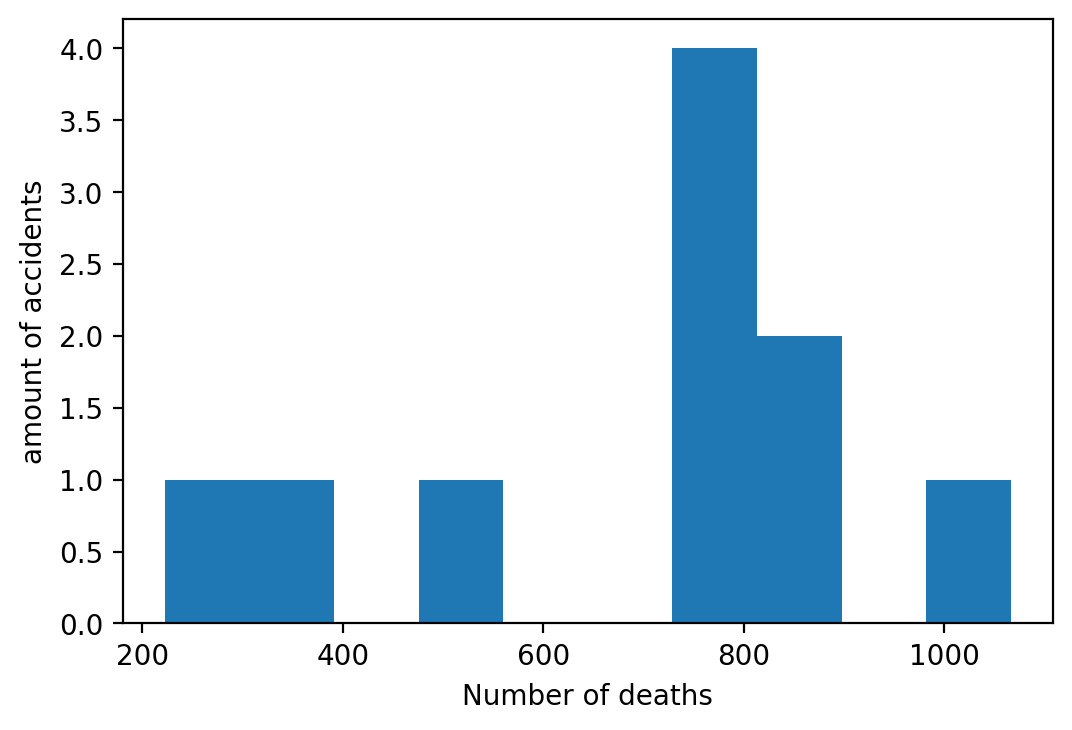

In [7]:
plt.hist(Airline_data['Passenger deaths'])
plt.xlabel("Number of deaths")
plt.ylabel("amount of accidents")

In [8]:
Airline_data['Passenger deaths'].mean()

691.9

- It is easily visible, that values are spread from 200 to 1000, but with such small amount of samples it is not reasonable to draw any conclusions. However the mean value of the collection is equal to 691.9, which indicates higher values.

In [9]:
Lambda = Airline_data['Passenger deaths'].mean()

In [13]:
with open('PD_PPC.stan', 'r') as file:
    print(file.read())

// Passenger deaths - prior predictive checks
generated quantities {
    // During prior prediction we shouldn't look to data but we don't have to much knowledge about how many people die per year in plane accidents
    // So I decided to use mean value of deaths from data and select wide sigma to catch all possibilities
    real lambda = normal_rng(692,200);
    int deaths = poisson_rng(lambda);
}


In [14]:
model_ppc=stan_utility.compile_model('PD_PPC.stan')

Using cached StanModel


In [15]:
R = 1000
sim = model_ppc.sampling(data=dict(),
                         iter=R,
                         warmup=0,
                         refresh=R,
                         algorithm='Fixed_param',
                         seed=43541)

In [16]:
params_sim=sim.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

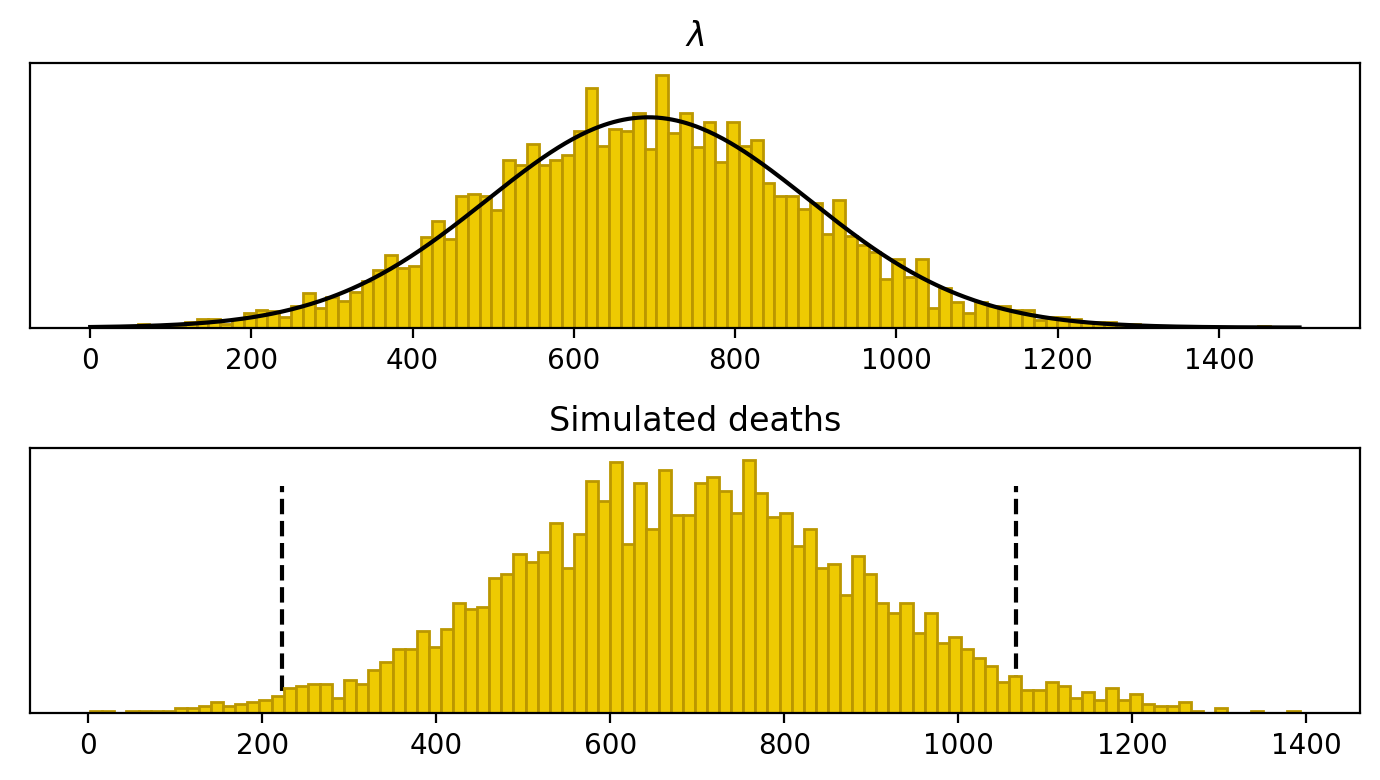

In [17]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([Airline_data['Passenger deaths'].min(),Airline_data['Passenger deaths'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
# ax1.set_yticks([])
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=200)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

- Simulating the values allows operating on the bigger collection. According to the fact, that real values match the simulated ones, the result is positive.

In [18]:
with open('PD_fit.stan', 'r') as file:
    print(file.read())

data {
    int N; //Number of our samples from data
    int deaths[N]; //Our deaths per year from data
}

parameters{
    real<lower=0> lambda;
}

model {
    lambda ~ normal(692,200);
    deaths ~ poisson(lambda);
}

generated quantities {
    int death = poisson_rng(lambda);
}


In [19]:
model_fit=stan_utility.compile_model('PD_fit.stan')

Using cached StanModel


In [20]:
fit=model_fit.sampling(data=dict(N=len(Airline_data['Passenger deaths']),
                                 deaths=Airline_data['Passenger deaths']),
                       seed=43541)

In [21]:
az.summary(fit,var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
lambda,691.69,8.48,676.13,707.69


The mean value is pretty close to the others, according to the fact, that the input data has been used for prediction. It is not good habit, but something is better than nothing.

In [22]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['death']

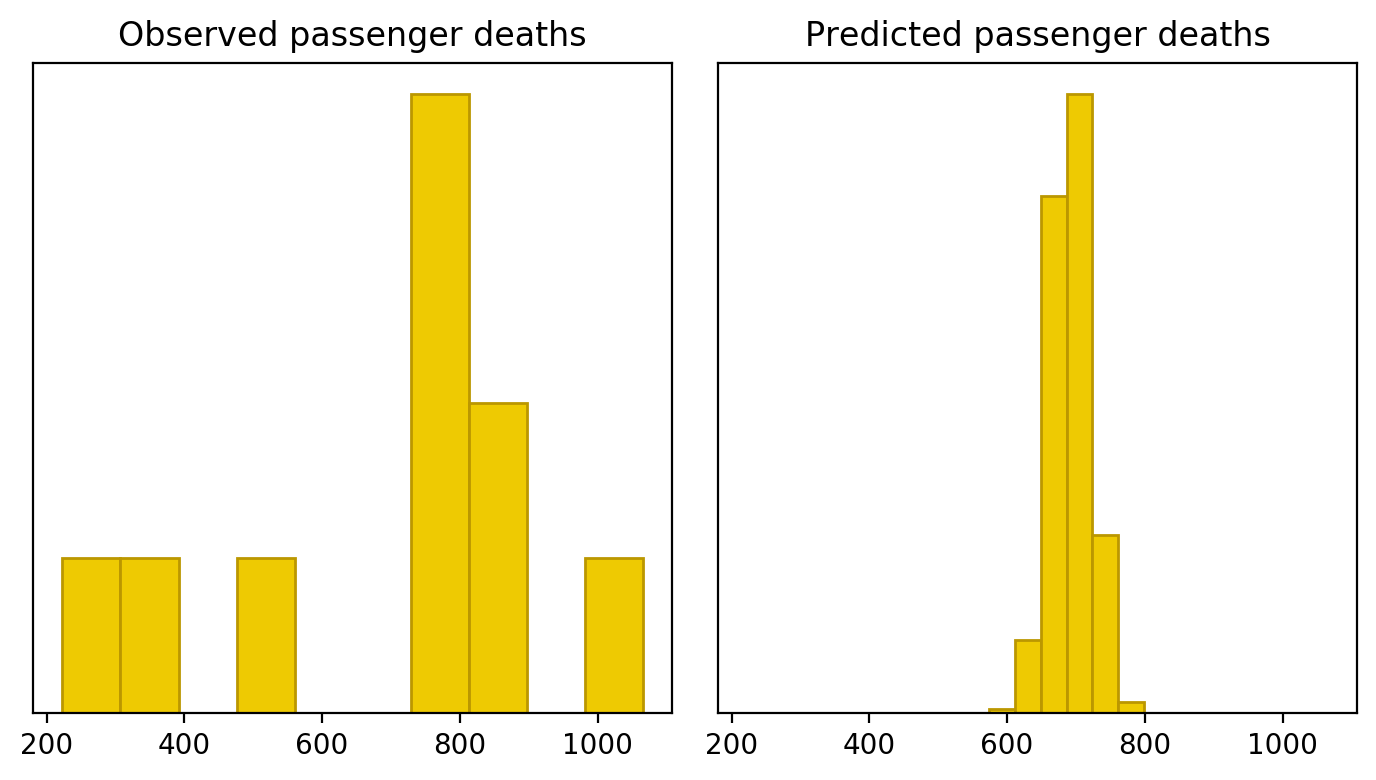

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax=axes[0]
ax.hist(Airline_data['Passenger deaths'],color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('Observed passenger deaths')
ax.set_yticks(());
ax2=axes[1]
ax2.hist(deaths_pred,bins=6,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted passenger deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

With this amount of input data it is hard to predict anything, because the model can differ from the real values.

Conclusion 2.
The intensity of deaths is constant, but its occurance comes from the intensity and the amount of miles flown.